# Task 4

Find the lowest eigenvalue of the following matrix:

$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0  \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

using VQE-like circuits, created by yourself from scratch.

# 1) Decomposing the desired matrix into pauli operators

Since we want to measure a VQE-like circuit, we need to decompose the matrix into their pauli components. We have that the pauli matrices are:

$$
\sigma_x = \begin{pmatrix}
    0 & 1 \\
    1 & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_y = \begin{pmatrix}
    0 & -i \\
    i & 0
    \end{pmatrix} \hspace{1em} , \hspace{1em}  \sigma_z = \begin{pmatrix}
    1 & 0 \\
    0 & -1
    \end{pmatrix}
$$

Thus to get the pauli component of a Matrix $2^N$ x $2^N$ matrix $A$, as stated on [stackoverflow](https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis), we have:

$$
A = \sum_{ij} \frac{1}{4} h_{ij} \hspace{0.5em} \sigma_i \otimes \sigma_j
$$

And the components $h_{ij}$ are:

$$
h_{ij} = \frac{1}{4} \mathrm{Tr} \bigg[ (\sigma_i \otimes \sigma_j) \cdot A \bigg]
$$

In [36]:
import matplotlib.pyplot as plt

In [135]:
import numpy as np
A = np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])
print(A)
# Defining Pauli Matrices
pauli_x = np.array([[0,1],[1,0]]) ; pauli_y = np.array([[0,1j],[-1j,0]]) ; pauli_z = np.array([[1,0],[0,-1]])

name_basis = ['I', 'X', 'Y', 'Z']
basis = [np.eye(2), pauli_x, pauli_y, pauli_z]

[[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]


In [146]:
from itertools import product

def get_components_from_matrix(A, basis, name_basis):
    
    components = []
    components_names = []
    components_dict = {}
    for (name_1, pauli_1),(name_2, pauli_2) in product(zip(name_basis, basis),zip(name_basis, basis)):        
        components_dict[name_1 + name_2] = np.trace(1/4.*np.kron(pauli_1,pauli_2) @ A)
    return components_dict

In [147]:
from itertools import product
components = get_components_from_matrix(A, basis, name_basis)

print("Decomposition:")
for name, comp in components.items():
    print(f"  {name} : {comp}")

# Now we can clean the dictionary removing keys that their 
# values are 0
cleaned_components = { key : val for key,val in components.items() if val != 0}
    
print("Clean decomposition:")
for name, comp in cleaned_components.items():
    print(f"  {name} : {comp}")

Decomposition:
  II : 0.5
  IX : 0.0
  IY : 0j
  IZ : 0.0
  XI : 0.0
  XX : -0.5
  XY : 0j
  XZ : 0.0
  YI : 0j
  YX : 0j
  YY : (-0.5+0j)
  YZ : 0j
  ZI : 0.0
  ZX : 0.0
  ZY : 0j
  ZZ : 0.5
Clean decomposition:
  II : 0.5
  XX : -0.5
  YY : (-0.5+0j)
  ZZ : 0.5


In [170]:
print("decomposition of A:")
decomp = 0.5*np.kron(np.eye(2), np.eye(2)) - 0.5*np.kron(pauli_x, pauli_x) - 0.5*np.kron(pauli_y, pauli_y)  + 0.5*np.kron(pauli_z, pauli_z)
print(f"""{decomp}""")

decomposition of A:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


Now we know that the desired matrix, has the following pauli decomposition:

$$
A = 0.5 I \otimes I \ - \ 0.5 \sigma_x \otimes \sigma_x \ - \ 0.5 \sigma_y \otimes \sigma_y \ + \ 0.5 \sigma_z \otimes \sigma_z
$$

# 2) Creating VQE circuit

Now we want to construct the VQE and measure the pauli factors in order to get the lowest eigenvalue of $A$. This is done in three parts:
- 1) Construct the VQE Ansatz;
- 2) Construct XX, YY, and ZZ measurements;
- 3) Vary VQE Ansatz parameters and measure the eigenvalue.

## 2.1) Creating Ansatz

In order to create the Variational Ansatz, we need to create a parametrized circuit in Qiskit. This is done by using the `parameter` class in `qiskit.circuit`. 

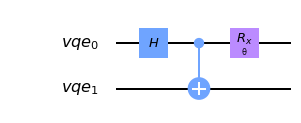

In [184]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

theta = Parameter('θ')

qr = QuantumRegister(2, name='vqe')
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.rx(theta, qr[0])
qc.draw('mpl')

## 2.2) Constructing XX, YY, and ZZ measurements



### 2.2.1) Constructing ZZ measurement

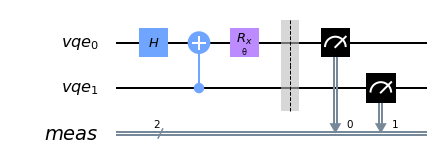

In [150]:
def measure_zz_circuit(circuit):
    """Measure the ZZ Component of the variational circuit."""
    zz_meas = circuit.copy()
    zz_meas.measure_all()
    return zz_meas

zz_meas = measure_zz_circuit(qc)
zz_meas.draw('mpl')

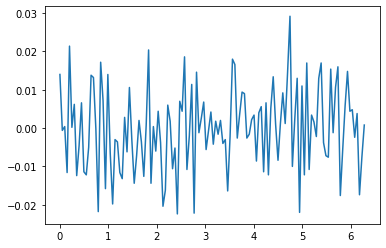

In [151]:
from qiskit import Aer, execute
def measure_zz(given_circuit, num_shots = 10000):

    zz_meas = measure_zz_circuit(given_circuit)
    theta_range = np.linspace(0, 2 * np.pi, 128)

    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(zz_meas,
              backend= simulator,
              shots= num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    zz = []

    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0        

        total_counts = count['00'] + count['11'] + count['01'] + count['10']

        zz_meas = count['00'] + count['11'] - count['01'] - count['10']
        zz.append(zz_meas / total_counts)
    
    return theta_range, zz

theta_range, zz = measure_zz(qc)
plt.plot(theta_range, zz);

### 2.2.2) Constructing YY measurement

In [181]:
def measure_yy_circuit(circuit):
    """Measure the YY Component of the variational circuit."""
    yy_meas = circuit.copy()
    yy_meas.h(range(2))
    yy_meas.sdg(range(2))
    yy_meas.measure_all()
    return yy_meas

yy_meas = measure_yy_circuit(qc)
yy_meas.draw()

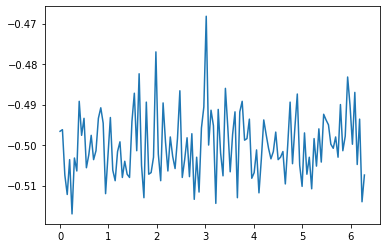

In [153]:
from qiskit import Aer, execute
def measure_yy(given_circuit, num_shots = 10000):

    yy_meas = measure_yy_circuit(given_circuit)
    
    theta_range = np.linspace(0, 2 * np.pi, 128)

    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(yy_meas,
              backend= simulator,
              shots=num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    yy = []
    
    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0        
        
        total_counts =  count['00'] + count['11'] + count['01'] + count['10']
        
        yy_meas = - count['00'] + count['11'] - count['01'] - count['10']
        yy.append(yy_meas / total_counts)
    
    return theta_range, yy

theta_range, yy = measure_yy(qc)
plt.plot(theta_range, yy);

### 2.2.3) Constructing XX measurement

In [154]:
def measure_xx_circuit(circuit):
    """Measure the XX Component of the variational circuit."""
    xx_meas = circuit.copy()        
    xx_meas.h(range(2)) 
    xx_meas.measure_all()    
    return xx_meas

xx_meas = measure_xx_circuit(qc)
xx_meas.draw()

┌───┐┌───┐┌───────┐┌───┐ ░ ┌─┐   
 vqe_0: ┤ H ├┤ X ├┤ RX(θ) ├┤ H ├─░─┤M├───
        └───┘└─┬─┘└─┬───┬─┘└───┘ ░ └╥┘┌─┐
 vqe_1: ───────■────┤ H ├────────░──╫─┤M├
                    └───┘        ░  ║ └╥┘
meas_0: ════════════════════════════╩══╬═
                                       ║ 
meas_1: ═══════════════════════════════╩═

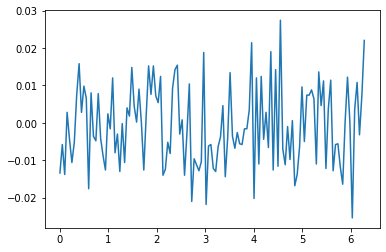

In [155]:
from qiskit import Aer, execute
def measure_xx(given_circuit, num_shots = 10000):

    xx_meas = measure_xx_circuit(given_circuit)
    
    theta_range = np.linspace(0, 2 * np.pi, 128)

    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(xx_meas,
              backend= simulator,
              shots=num_shots,
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])
    
    counts = job.result().get_counts()

    xx = []
    
    for count in counts:        
        if '00' not in count:
            count['00'] = 0
        if '01' not in count:
            count['01'] = 0
        if '10' not in count:
            count['10'] = 0
        if '11' not in count:
            count['11'] = 0                
        total_counts = count['00'] + count['11'] + count['01'] + count['10']
        
        xx_meas = count['00'] + count['11'] - count['01'] - count['10']
        xx.append(xx_meas / total_counts)
    
    return theta_range, xx

theta_range, xx = measure_xx(qc)
plt.plot(theta_range, xx);

## 2.3) Getting the eigenvalue

In [185]:
def get_energy(circuit, num_shots = 10000):
    
    theta, xx = measure_xx(circuit, num_shots = num_shots)
    _, yy = measure_yy(circuit, num_shots = num_shots)
    _, zz = measure_zz(circuit, num_shots = num_shots)    
    xx, yy, zz = np.array(xx), np.array(yy), np.array(zz)
    
    energy = 0.*1 \
             - 0.5*xx \
             - 0.5*yy \
             + 0.5*zz
    
    return theta, energy

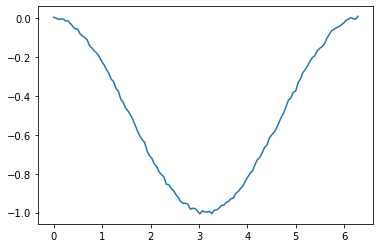

In [186]:
thetas, energy = get_energy(qc)
plt.plot(thetas, energy)
plt.show()

In [187]:
np.round(np.min(energy),4)

-1.0067

In [188]:
thetas[np.argmin(energy)]

3.017907903448463

--------------------------------------------

In [130]:
np.linalg.eig(2*pauli_z + pauli_x + np.eye(2))

(array([ 3.23606798, -1.23606798]), array([[ 0.97324899, -0.22975292],
        [ 0.22975292,  0.97324899]]))

In [247]:
np.linalg.eig(A)

(array([ 1., -1.,  1.,  1.]),
 array([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [-0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

State solution: $\frac{1}{2} (-|0\rangle + |1\rangle) \otimes |0 \rangle$

In [86]:
np.round(1/np.sqrt(2)*np.kron(np.array([1,0]),np.array([-1,1])),5)

array([-0.70711,  0.70711,  0.     ,  0.     ])

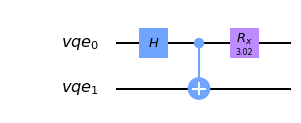

In [190]:
qr = QuantumRegister(2, name='vqe')
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.rx(3.017, qr[0])
qc.draw('mpl')

In [191]:
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')
# Create a Quantum Program for execution
job = execute(qc, backend)
result = job.result()
outputstate = result.get_statevector(qc, decimals=5)
print(outputstate)

[ 0.04402+0.j       0.     -0.70574j -0.     -0.70574j  0.04402+0.j     ]


--------------------------------------------------------------------

In [1]:
from qiskit.tools.jupyter import *
%qiskit_version_table